In [1]:
%pip install qiskit-nature
%pip install pyscf
%pip install qiskit==1.4.2
%pip install matplotlib
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 0. Imports

from tqdm import tqdm
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit

# I. define the H2 molecule for a range of 11 inter-atomic distances between 0.5 A and 2.5 A

# 1. Define the distances you want to check
distances_to_check = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]

# 2. Define the basic, unchanging properties of the molecule
molecule_name = "H2"
charge = 0
spin = 0 # (for H2, this means no net spin)


list_of_quantum_problems = []
for r in tqdm(distances_to_check):
    
    # 1. THE INPUT (for this loop iteration)
    # Define the "geometry" for this specific distance 'r'
    # This is the "recipe" you give to the classical driver.
    current_geometry = f"H 0 0 0; H 0 0 {r}"
    # This string says:
    # "Put one Hydrogen atom at (0, 0, 0)"
    # "Put the other Hydrogen atom at (0, 0, r)"
    
    # 2. THE "MAGIC" (The Task Itself)
    # You tell Qiskit Nature to...
    # ...use PySCF (the "driver")...
    # ...to "define" the molecule...
    # ...using your 'current_geometry', 'charge', and 'spin'.
    
    problem_at_this_distance = PySCFDriver(
        atom=current_geometry,
        basis="sto3g",
        charge=charge,
        spin=spin,
        unit=DistanceUnit.ANGSTROM
    ).run() 
    
    # 3. THE OUTPUT (for this loop iteration)
    # The 'problem_at_this_distance' object is your output.
    # It's a big, complex Python object that contains *everything*
    # the classical calculator figured out.
    
    # You then save this object to your list.
    list_of_quantum_problems.append(problem_at_this_distance)

print(f"Generated {len(list_of_quantum_problems)} problems for H2.\n")

100%|██████████| 11/11 [03:37<00:00, 19.77s/it]

Generated 11 problems for H2.



In [3]:
import numpy as np
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.formats import MoleculeInfo


# II. Generate the Hamiltonian: 
# For each distance r i r i ​ , generate the corresponding 
# Electronic Structure Hamiltonian in the second-quantized form, 
# map it to a Qubit Hamiltonian (using mappers like Jordan-Wigner or Parity), 
# and reduce the number of qubits using symmetries.

# We will store our final translated "quantum recipes" here
mapped_hamiltonians = []
# We also save the mappers, as they are crucial for VQE
reduced_mappers = {}

# Choose your mapper. JordanWignerMapper is a great default.
# ParityMapper is another good choice that also reduces 2 qubits.
mapper_type = JordanWignerMapper() 
# mapper_type = ParityMapper()

for i, problem in enumerate(list_of_quantum_problems):
    distance = distances_to_check[i]
    print(f"Processing distance r = {distance:.2f} Å...")

    # 1. Get the second-quantized Hamiltonian CONTAINER
    hamiltonian_2q_container = problem.hamiltonian

    # Get the operator (a FermionicOp) from the ElectronicEnergy container
    hamiltonian_2q_op = hamiltonian_2q_container.second_q_op()
    # ------------------------------------------------
    
    # 2. Reduce the number of qubits using symmetries
    tapered_mapper = problem.get_tapered_mapper(mapper_type)

    # 3. Map the second-quantized OPERATOR to a Qubit Hamiltonian
    # --- FIX: We map the operator (hamiltonian_2q_op), not the container ---
    qubit_hamiltonian = tapered_mapper.map(hamiltonian_2q_op)

    # --- Let's see the effect of the reduction ---
    # For H2, we have 2 spatial orbitals (1s_A, 1s_B)
    # This means 2 * 2 = 4 qubits originally (spin-up/down for each)
    num_qubits_original = problem.num_spatial_orbitals * 2
    num_qubits_reduced = qubit_hamiltonian.num_qubits
    
    print(f"  Original number of qubits: {num_qubits_original}")
    print(f"  Number of qubits after symmetry reduction: {num_qubits_reduced}")

    # 4. Save the results for this distance
    mapped_hamiltonians.append(qubit_hamiltonian)
    reduced_mappers[distance] = tapered_mapper

print("\nTask complete. We now have:")
print(f"1. 'mapped_hamiltonians': A list of {len(mapped_hamiltonians)} Qubit Hamiltonians.")
print(f"2. 'reduced_mappers': A dictionary of mappers for each distance.")

Processing distance r = 0.50 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 0.70 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 0.90 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.10 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.30 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.50 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.70 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 1.90 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduction: 1
Processing distance r = 2.10 Å...
  Original number of qubits: 4
  Number of qubits after symmetry reduc

Running VQE calculations for each distance...
  Distance: 0.50 Å, Total Energy: -1.055160 Hartree
  Distance: 0.70 Å, Total Energy: -1.136189 Hartree
  Distance: 0.90 Å, Total Energy: -1.120560 Hartree
  Distance: 1.10 Å, Total Energy: -1.079193 Hartree
  Distance: 1.30 Å, Total Energy: -1.035186 Hartree
  Distance: 1.50 Å, Total Energy: -0.998149 Hartree
  Distance: 1.70 Å, Total Energy: -0.971427 Hartree
  Distance: 1.90 Å, Total Energy: -0.954339 Hartree
  Distance: 2.10 Å, Total Energy: -0.944374 Hartree
  Distance: 2.30 Å, Total Energy: -0.938922 Hartree
  Distance: 2.50 Å, Total Energy: -0.936055 Hartree

Plotting results...
Equilibrium distance (r_eq) found at: 0.700 Å


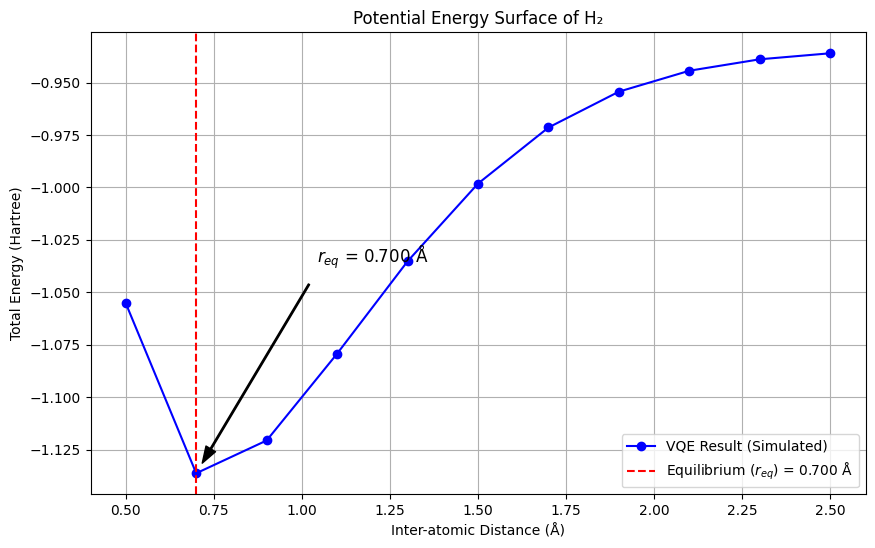

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorEstimator

# III. VQE Implementation

# --- 3a. Define the components from your image ---

# 1. The "Quantum" Part: Ansatz
# We'll use the "simpler EfficientSU2" as suggested.
# We get the number of qubits from our reduced Hamiltonian.
num_qubits = mapped_hamiltonians[0].num_qubits
ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='linear')

# 2. The "Classical" Part: Optimizer
# We'll use "SLSQP" as suggested.
optimizer = SLSQP(maxiter=1000)

# 3. The "Calculator": Estimator
# This is the "backend" that runs the circuit and calculates
# the expectation value <Psi|H|Psi>.
estimator = StatevectorEstimator()

# --- 3b. Build the VQE Solver ---
# The VQE algorithm "glues" the estimator, ansatz, and optimizer together.
vqe_solver = VQE(estimator, ansatz, optimizer)

# --- 3c. Run the VQE loop to find the energy for EACH distance ---
# We will store our final energy points here
vqe_energies = []
print("Running VQE calculations for each distance...")

for i in range(len(distances_to_check)):
    dist = distances_to_check[i]
    problem = list_of_quantum_problems[i]
    qubit_ham = mapped_hamiltonians[i]

    # Run the VQE algorithm!
    # This automatically does the optimization: "find the parameters (theta)
    # that minimize the expectation value"
    vqe_result = vqe_solver.compute_minimum_eigenvalue(qubit_ham)
    
    # The VQE result is *only* the electronic energy
    vqe_electronic_energy = vqe_result.eigenvalue.real
    
    # We must add the nuclear repulsion energy (a simple classical value)
    # to get the *total* energy of the molecule.
    nuclear_repulsion_energy = problem.hamiltonian.nuclear_repulsion_energy
    total_energy = vqe_electronic_energy + nuclear_repulsion_energy
    
    vqe_energies.append(total_energy)
    print(f"  Distance: {dist:.2f} Å, Total Energy: {total_energy:.6f} Hartree")

# --- 3d. Plot the Final Potential Energy Surface ---
print("\nPlotting results...")
plt.figure(figsize=(10, 6))

# Plot the Potential Energy Curve
plt.plot(distances_to_check, vqe_energies, 'bo-', label='VQE Result (Simulated)')

# Find the index of the minimum energy
min_energy_index = np.argmin(vqe_energies)

# Get the corresponding distance and energy
req_distance = distances_to_check[min_energy_index]
min_energy = vqe_energies[min_energy_index]

print(f"Equilibrium distance (r_eq) found at: {req_distance:.3f} Å")

# Add a vertical dashed line to mark r_eq
plt.axvline(x=req_distance, color='red', linestyle='--', 
            label=f'Equilibrium ($r_{{eq}}$) = {req_distance:.3f} Å')

# Add an annotation arrow and text
plt.annotate(
    f'$r_{{eq}}$ = {req_distance:.3f} Å',
    xy=(req_distance, min_energy),           # The point to annotate (the arrow tip)
    xytext=(req_distance + 0.5, min_energy + 0.1), # Where to put the text
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
    fontsize=12,
    ha='center'
)

plt.xlabel('Inter-atomic Distance (Å)')
plt.ylabel('Total Energy (Hartree)')
plt.title('Potential Energy Surface of H₂')
plt.grid(True)
plt.legend() # Call legend() *after* adding all labeled elements
plt.show()